# Creating a wildtype (WT / PD0), and Parkinson degeneration (PD2) network

In the directory ```network_path``` we have three sub directories ```PD0```, ```PD2-ref``` and ```PD2```. In order to generate the ```PD2``` network, we degenerate the ```PD0``` network by swapping the WT morphologies for the PD2 morphologies. In addition a subset of the synapses in the ```PD2-ref``` network are added to compensate for differences in pruning.

We need to specify a ```connection_override``` file. The difference compared to the standard connection file is that it contains ```recovery``` information, i.e. the fraction of synapses from the ```PD2-ref``` network that should be added to the ```PD2``` network.

The ```rc``` object is a ```ipyparallel``` ```RemoteClient``` object for parallel execution.

If you want to remap external input that was removed to a new position, then use ```remap_removed_input = True```

In [1]:
import os

network_path = os.path.join("networks","PD-example-2")

network_path_pd0 = os.path.join(network_path, "PD0")
network_path_pd2_ref = os.path.join(network_path, "PD2-ref")
network_path_pd2 = os.path.join(network_path, "PD2")

network_size = 200
input_config = "test-input.json"  # Only background input will be used in this example

snudda_data_base_path = os.path.join("..", "..", "..", "..", "BasalGangliaData", "Parkinson", "20220225")
snudda_data_pd0 = os.path.join(snudda_data_base_path, "PD0")
snudda_data_pd2 = os.path.join(snudda_data_base_path, "PD2")

network_config_pd0 = os.path.join(snudda_data_base_path, "connectivity", "network-config.json")
network_config_pd2 = os.path.join(snudda_data_base_path, "connectivity", "network-config-PD-synapse-recovery.json")

input_pd0 = os.path.join(network_path_pd0, "input-spikes.hdf5")
input_pd2 = os.path.join(network_path_pd2, "input-spikes.hdf5")

# Do we want to remap removed input?
remap_removed_input = True
remapped_fraction = 0.7

rc = None

## First generate the WT reference network

In [2]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path_pd0, random_seed=123456, snudda_data=snudda_data_pd0,
                struct_def={"Striatum": network_size}, connection_override_file=network_config_pd0)

Adding Striatum with 200 neurons
Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD0/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD0/neurons/striatum/fs
No parameter.json file.
No parameter.json file.
No parameter.json file.
No parameter.json file.
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD0/neurons/striatum/fs/0/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD0/neurons/striatum/fs/0/mechanisms.json
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD0/neurons/striatum/fs/1/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD0/neurons/striatum/fs/1/mechanisms.json
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD0/neurons/striatum/fs/3/parameters.json
Mechanism file not found: /home/

In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path_pd0, verbose=False, rc=rc)
sp.place()

Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20220225/PD0 from networks/PD-example-2/PD0/network-config.json


In [4]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path_pd0, rc=rc)
sd.detect()

Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20220225/PD0 from networks/PD-example-2/PD0/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 36/180 (200 neurons)
Processing hyper voxel : 66/180 (190 neurons)
Processing hyper voxel : 41/180 (189 neurons)
Processing hyper voxel : 37/180 (156 neurons)
Processing hyper voxel : 71/180 (145 neurons)
Processing hyper voxel : 35/180 (127 neurons)
Processing hyper voxel : 67/180 (102 neurons)
Processing hyper voxel : 42/180 (93 neurons)
Processing hyper voxel : 31/180 (81 neurons)
Processing hyper voxel : 6/180 (81 neurons)
Processing hyper voxel : 65/180 (72 neurons)
Processing hyper voxel : 40/180 (68 neurons)
Processing hyper voxel : 72/180 (54 neurons)
Processing hyper voxel : 11/180 (50 neurons)
Processing hyper voxel : 61/180 (49 neurons)
Processing hyper voxel : 70/180 (30 neurons)
Processing hyper voxel : 5/180 (26 neurons)
Processing hyper voxel : 32/180 (25 neurons)
Proc

In [5]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path_pd0, rc=rc)
sp.prune()

Read 438271 out of total 438271 synapses
Read 5 out of total 5 gapJunctions


In [6]:
import os
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path_pd0, 
                 input_config_file=input_config,
                 verbose=False)
si.generate()

Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20220225/PD0 from networks/PD-example-2/PD0/network-config.json
Loading 200 neurons with 20809 synapses and 3 gap junctions
Writing spikes to networks/PD-example-2/PD0/input-spikes.hdf5


## Generate a PD2 reference network

This network will not have the same synapses as the WT, but it is used in order to add "recovery synapses" to compensate for part of the degeneration.

In [7]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path_pd2_ref, random_seed=123456, snudda_data=snudda_data_pd2,
                struct_def={"Striatum": network_size}, connection_override_file=network_config_pd2)

Adding Striatum with 200 neurons
Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD2/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD3/neurons/striatum/fs
No parameter.json file.
No parameter.json file.
No parameter.json file.
No parameter.json file.
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD3/neurons/striatum/fs/0/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD3/neurons/striatum/fs/0/mechanisms.json
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD3/neurons/striatum/fs/1/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD3/neurons/striatum/fs/1/mechanisms.json
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD3/neurons/striatum/fs/3/parameters.json
Mechanism file not found: /home/

In [8]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path_pd2_ref, verbose=False, rc=rc)
sp.place()

Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20220225/PD2 from networks/PD-example-2/PD2-ref/network-config.json


In [9]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path_pd2_ref, rc=rc)
sd.detect()

Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20220225/PD2 from networks/PD-example-2/PD2-ref/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 36/180 (200 neurons)
Processing hyper voxel : 41/180 (198 neurons)
Processing hyper voxel : 66/180 (176 neurons)
Processing hyper voxel : 71/180 (157 neurons)
Processing hyper voxel : 37/180 (150 neurons)
Processing hyper voxel : 42/180 (125 neurons)
Processing hyper voxel : 67/180 (91 neurons)
Processing hyper voxel : 35/180 (87 neurons)
Processing hyper voxel : 72/180 (73 neurons)
Processing hyper voxel : 40/180 (73 neurons)
Processing hyper voxel : 6/180 (69 neurons)
Processing hyper voxel : 11/180 (59 neurons)
Processing hyper voxel : 65/180 (41 neurons)
Processing hyper voxel : 31/180 (38 neurons)
Processing hyper voxel : 70/180 (32 neurons)
Processing hyper voxel : 7/180 (26 neurons)
Processing hyper voxel : 12/180 (22 neurons)
Processing hyper voxel : 61/180 (20 neurons)
P

In [10]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path_pd2_ref, rc=rc)
sp.prune()

Read 274545 out of total 274545 synapses
Read 5 out of total 5 gapJunctions


## Degenerating the PD0 network to get PD2 network

In [11]:
network_file_pd0 = os.path.join(network_path_pd0, "network-synapses.hdf5")
network_file_pd2_ref = os.path.join(network_path_pd2_ref, "network-synapses.hdf5")
network_file_pd2 = os.path.join(network_path_pd2, "network-synapses.hdf5")

from snudda.utils.swap_to_degenerated_morphologies_extended import SwapToDegeneratedMorphologiesExtended
swap = SwapToDegeneratedMorphologiesExtended(original_network_file=network_file_pd0,
                                             updated_network_file=network_file_pd2_ref,
                                             output_network_file=network_file_pd2,
                                             original_snudda_data_dir=snudda_data_pd0,
                                             updated_snudda_data_dir=snudda_data_pd2,
                                             original_input_file=input_pd0,
                                             output_input_file=input_pd2)
swap.write_new_network_file()
swap.write_new_input_file(remap_removed_input=remap_removed_input, remapped_fraction=remapped_fraction)
swap.close()

Loading 200 neurons with 20809 synapses and 3 gap junctions
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD2/neurons/striatum/fs/1/DR-rat-Mar-13-08-1-536-R-cor-rep-res3-61.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD2/neurons/striatum/chin/str-chin-e170614_cell6-m17JUL301751_170614_no6_MD_cell_1_x63-v20190710/optim_chin_morph_renamed2019-11-08.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD2/neurons/striatum/fs/3/MTC251001A-IDB-cor-rep-res3-61.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD2/neurons/striatum/fs/0/BE104E-cor-rep-res3-61.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20220225/PD2/neurons/striatum/lts/8/lts_morp_9862_centered_no_axon_resampled-var8.swc-cache.pickle
Loading 200 neurons with 8872 synapses and 3 gap junctions
Writing new network to 

## Plotting of a degenerated neuron

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20220225/PD0 from networks/PD-example-2/PD0/network-config.json
Loading 200 neurons with 20809 synapses and 3 gap junctions
Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20220225/PD2 from networks/PD-example-2/PD2/network-synapses.hdf5
Loading 200 neurons with 9347 synapses and 3 gap junctions
Plotting 200 external synapses
Plotting 178 external synapses
Synapse coordinates mismatch [[0.004734 0.004011 0.007851]] vs [[0.00474289 0.0040112  0.00784527]] (distances [1.05790223e-05] with allowed max_dist = 1e-05)
Synapse at 22 (0.085) dist 1.1e-05 has closer location 22 (0.170) dist 1.9e-06 (syn_voxels [148 176 176])
Figure written: networks/PD-example-2/PD2/figures/input-to-50-iSPN_21-and-internal-synapses.png


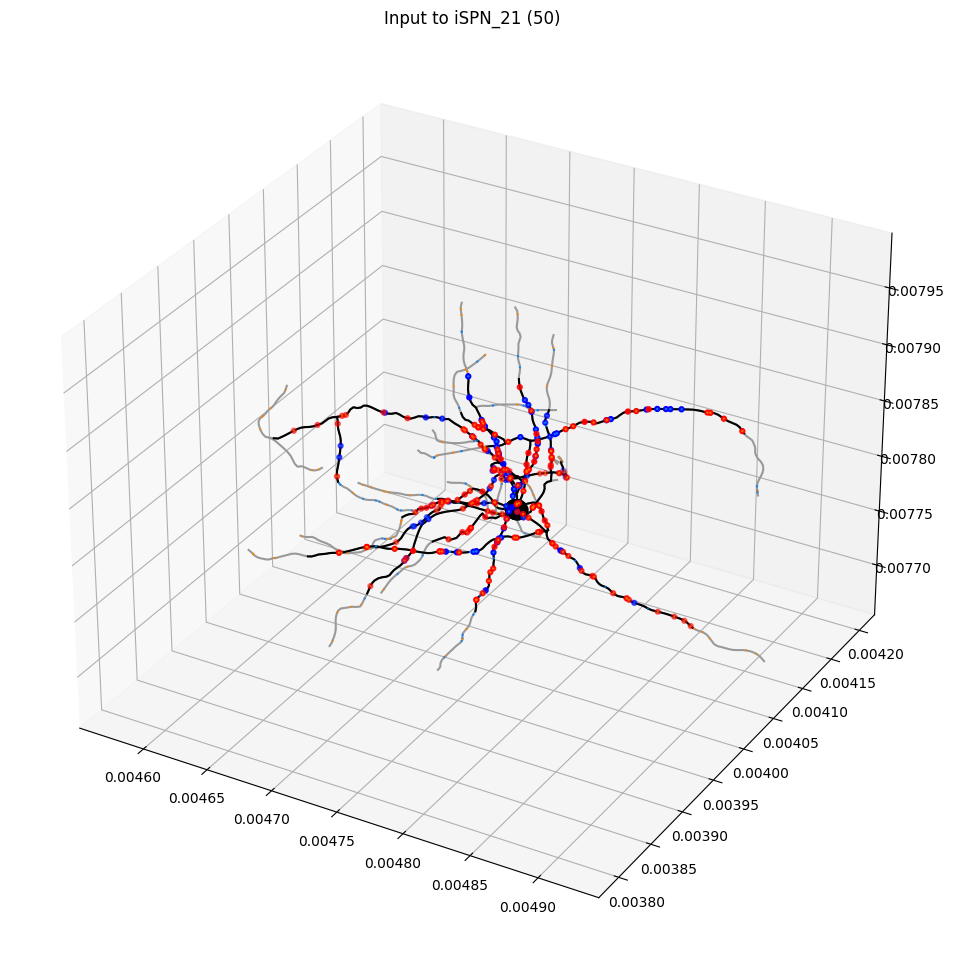

In [12]:
%matplotlib inline
from snudda.plotting.plot_degeneration import PlotDegeneration

pd = PlotDegeneration(original_network_path=network_path_pd0,
                      degenerated_network_path=network_path_pd2)
plot_neuron_id = 50
pd.plot_neuron(neuron_id=plot_neuron_id, figure_size=(12,12), show_internal_synapses=True)

In [13]:
from snudda.analyse.analyse_input import AnalyseInput

pd0_input_info = AnalyseInput(input_file=input_pd0, network_path=network_path_pd0)
pd2_input_info = AnalyseInput(input_file=input_pd2, network_path=network_path_pd2)

Loading 200 neurons with 20809 synapses and 3 gap junctions
Loading 200 neurons with 9347 synapses and 3 gap junctions


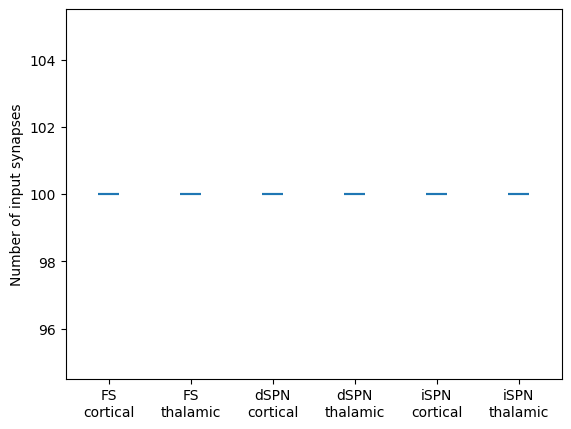

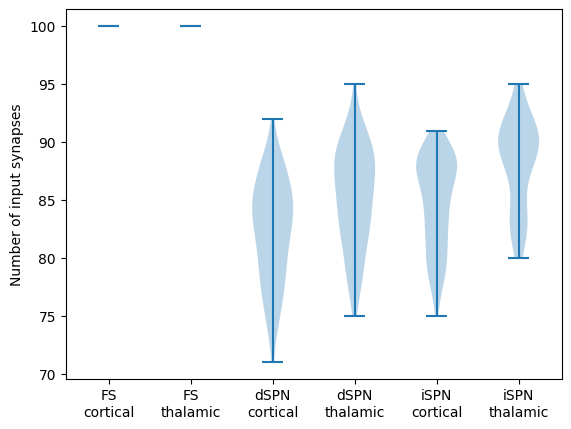

In [14]:
pd0_input_info.plot_input_count("PD0-input_example.png")
pd2_input_info.plot_input_count("PD2-input_example.png")